In [55]:
import numpy as np
import pandas as pd
import tensorflow as tf
import numba
import time
from timeit import default_timer as timer
from datetime import timedelta
from matplotlib import pyplot as plt

In [2]:
def timeit2(func):
    """
    Function decorator to evaluate execution time using the `time.process_time()` function.
    The execution time is printed to screen.
    """
    def wrapper(*args, **kwargs):
        t = time.process_time()
        value = func(*args, **kwargs)
        elapsed_time = time.process_time() - t
        print("Elapsed time for func {f}: {s} s".format(f=func.__name__, s=round(elapsed_time,4)))
        return value
    return wrapper

def timeit(func):
    """
    Function decorator to evaluate execution time using timeit's `timer` function.
    The execution time is converted to a time difference (timedelta) and returned as milliseconds,
    in a tuple together with the function return value.
    """
    def wrapper(*args, **kwargs):
        start = timer()
        value = func(*args,**kwargs)
        end = timer()
        t = timedelta(seconds=end-start)
        #print("Time elapsed for func {f}: {t} s".format(f=func.__name__,t=t))
        return (value, t.total_seconds() * 1000)
    return wrapper

## Exercise 1: Numpy basics

In [3]:
a = np.array([[0.5, -1], [-1, -2]], dtype=np.float32)
assert a.shape == (2,2)
assert a.ndim == 2
b = a.copy().flatten()
b[1::2] = 0

## Exercise 2: Numpy performance

In [4]:
@timeit
def mydot(a, b):
    c = [[0 for j in range(len(b[i]))] for i in range(len(a))]

    for i in range(len(c)):
        for j in range(len(c[i])):
            t = 0
            for k in range(len(b)):
                t += a[i][k] * b[k][j]
            c[i][j] = t
    return c

@timeit
@numba.jit(nopython=True)
def myfastdot(a,b):
    c = np.zeros( (len(a), len(b[0])))

    for i in range(len(c)):
        for j in range(len(c[i])):
            t = 0
            for k in range(len(b)):
                t += a[i][k] * b[k][j]
            c[i][j] = t
    return c
    

@timeit
def numpydot(a,b):
    return np.dot(a,b)

In [5]:
Ns = np.array([5, 10, 25, 50, 100, 250, 500, 750])
my_y = []
numpy_y = []
numba_y = []
for N in Ns:
    a = np.random.rand(N,N)
    b = np.random.rand(N,N)
    my_y.append(mydot(a,b)[1])
    numba_y.append(myfastdot(a,b)[1])
    numpy_y.append(numpydot(a,b)[1])

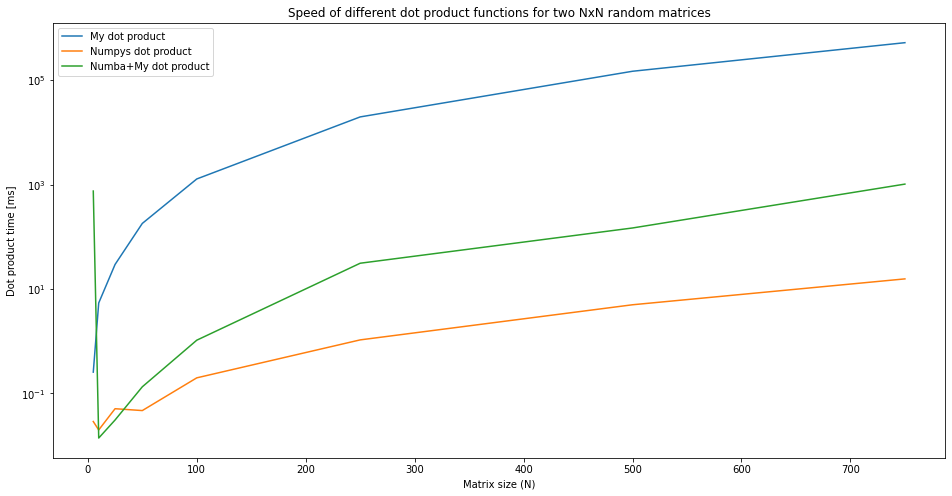

In [6]:
fig, ax = plt.subplots(figsize=(16,8))
plt.title("Speed of different dot product functions for two NxN random matrices")
plt.xlabel("Matrix size (N)")
plt.ylabel("Dot product time [ms]")
plt.yscale("log")
plt.plot(Ns, my_y, label="My dot product")
plt.plot(Ns, numpy_y, label="Numpys dot product")
plt.plot(Ns, numba_y, label="Numba+My dot product")
plt.legend()
plt.show()

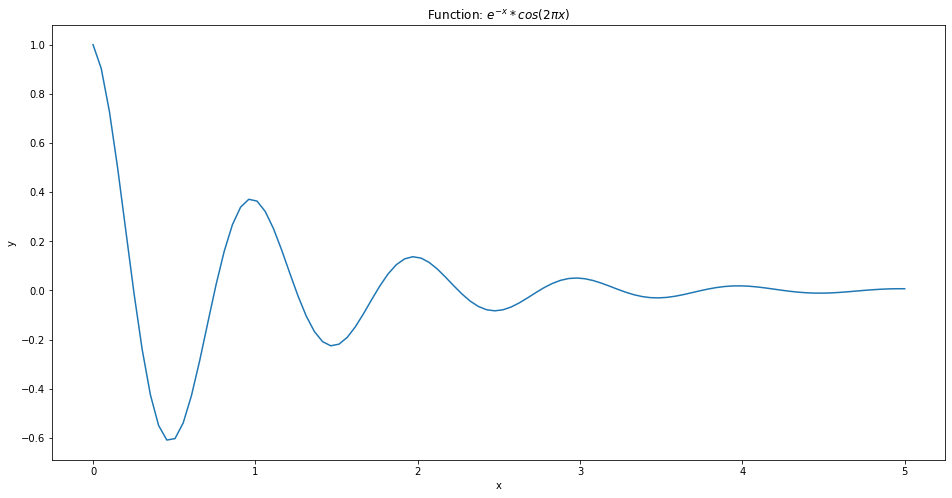

In [15]:
def f(x):
    return np.exp(-x) * np.cos(2*np.pi*x)

x = np.linspace(0,5, num=100)
y = f(x)

fig, ax = plt.subplots(figsize=(16,8))
plt.title(r"Function: $e^{-x} * cos(2\pi x)$")
plt.xlabel("x")
plt.ylabel("y")
plt.plot(x,y)
plt.show()

## Exercise 4: Scatter plot

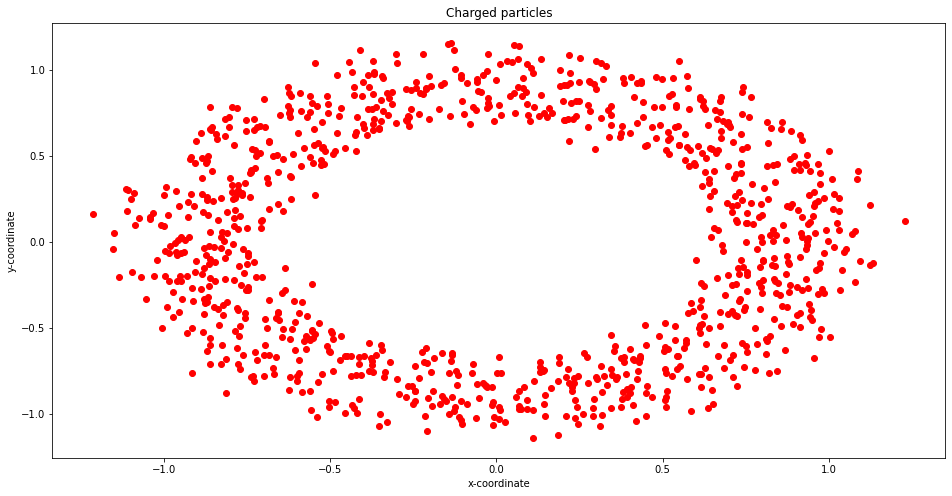

In [24]:
x,y = np.loadtxt("data4.dat", unpack=True)

fig, ax = plt.subplots(figsize=(16,8))
plt.title("Charged particles")
plt.xlabel("x-coordinate")
plt.ylabel("y-coordinate")
plt.scatter(x,y, c="red")
plt.savefig("output.png", bbox_inches="tight")

## Exercise 5 - Function plotting

In [45]:
def ToString(x):
    string = ""
    for row in x:
        string += '\t'.join(map(lambda x: "{:.3f}\t".format(x), row))
        string += "\n"
    return string

def f(x):
    return np.sin(x*x)/x + (0.01 * x**2)

x = np.linspace(-3, 3, num=100)
file = open("output.dat", "w+")
stacked = np.column_stack((x, f(x)))
file.write(ToString(stacked))

1498

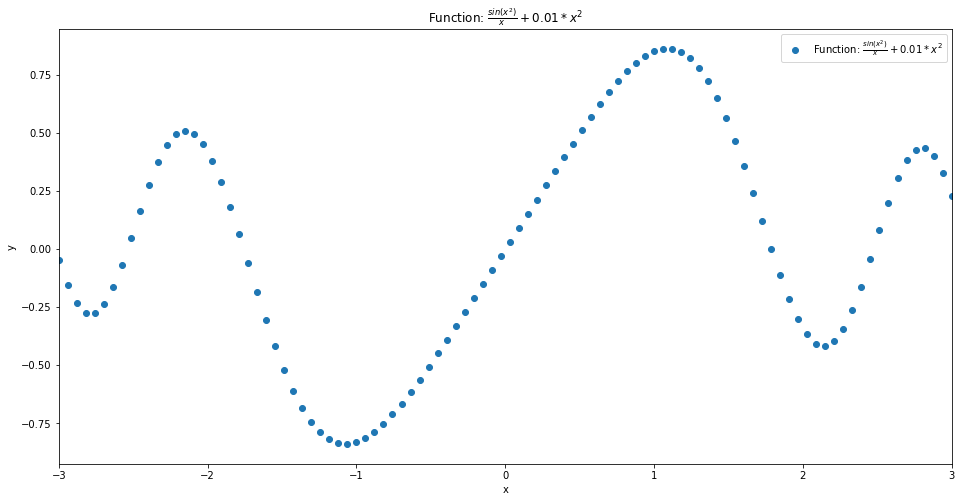

In [53]:
fig, ax = plt.subplots(figsize=(16,8))
plt.scatter(x, f(x), label=r"Function: $\frac{sin(x^2)}{x} + 0.01 * x^2$")
plt.title(r"Function: $\frac{sin(x^2)}{x} + 0.01 * x^2$")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim((-3,3))
plt.legend()
plt.savefig("output5.png", bbox_inches="tight")

## Exercise 6 - Pandas basics

In [58]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,na_values='?', comment='\t', sep=' ', skipinitialspace=True)
filtered = raw_dataset[raw_dataset["Cylinders"] == 3]

      MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
71   19.0          3          70.0        97.0  2330.0          13.5   
111  18.0          3          70.0        90.0  2124.0          13.5   
243  21.5          3          80.0       110.0  2720.0          13.5   
334  23.7          3          70.0       100.0  2420.0          12.5   

     Model Year  Origin  
71           72       3  
111          73       3  
243          77       3  
334          80       3  


## Exercise 7 - Polynomial fit

In [258]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def true_function(x):
    x = np.array(x)
    return np.cos(1.5 * np.pi * x)

def polynomial(x,a,b,c,d):
    return a + b*x + c*x**2 + d*x**3

## Poly regression
def prepare_dataset(plot=False):
    x = np.random.rand(30)
    y = true_function(x) + np.random.rand() * 0.1
    if plot:
        fig, ax = plt.subplots(figsize=(14,8))
        plt.plot(x,y)
    return x,y

def normalize_dataset(x,y):
    return (x/max(x), y/max(y))


def poly_regression(degree: int, plterror=False):
    x,y = normalize_dataset(*prepare_dataset())
    # create polynomial regression
    poly = PolynomialFeatures(degree=degree)
                                  
    x2 = poly.fit_transform(x.reshape(-1,1))
    model = tf.keras.Sequential(
        [
            keras.layers.Dense(degree+1, input_shape=[degree+1]),
            keras.layers.Dense(1)
        ]
    )
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    tf_history = model.fit(x2, y, epochs=500, batch_size=32, verbose=False)
    if plterror:
        plt.plot(tf_history.history['loss'])
        plt.xlabel('Epochs')
        plt.ylabel('MSE Loss')
        plt.show()
    
    mse = tf_history.history['loss'][-1]
    y_hat = model.predict(x2)
    
    plt.figure(figsize=(12,7))
    plt.title('Polynomial fit with degree {}'.format(degree))
    plt.scatter(x2[:,1], y, label=r'Data $(X, y)$: $cos(1.5\pi x)$')
    plt.scatter(x2[:,1], y_hat, color='red', label='Polynomial prediction (degree {})'.format(degree),linewidth=4.0)
    plt.xlabel('$X$', fontsize=20)
    plt.ylabel('$y$', fontsize=20)
    plt.text(0,0.70,'MSE = {:.3f}'.format(mse), fontsize=20)
    plt.grid(True)
    plt.legend(fontsize=20)
    plt.show()

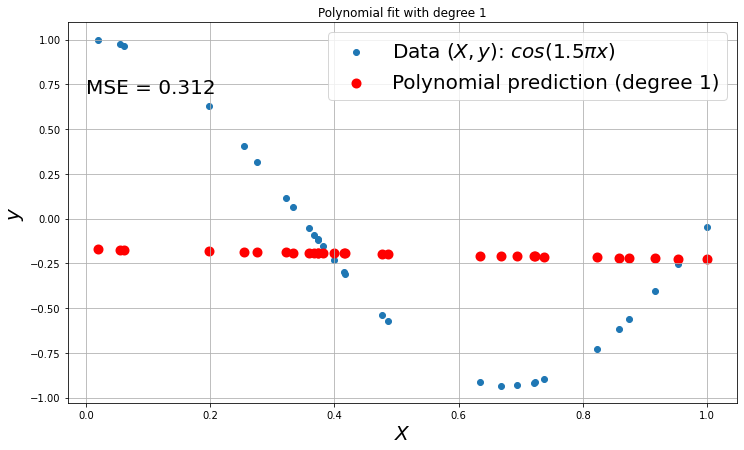

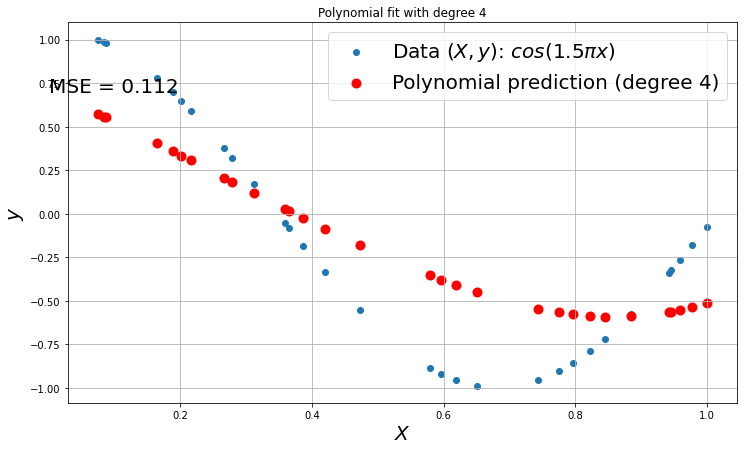

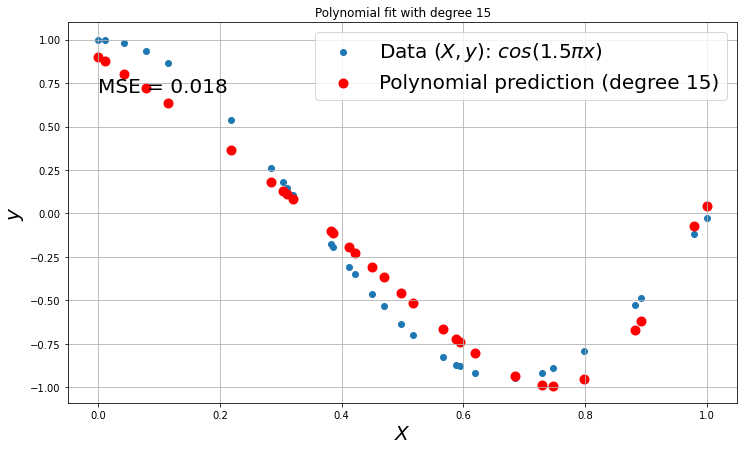

In [264]:
# ns = [1]+[2*i for i in range(1,7)]
ns = (1,4,15)
for n in ns:
    poly_regression(n)